In [ ]:
import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pyproj import Proj, transform

In [ ]:
local_crs = 27700
place = "glasgow"
lat = 55.86421405612109
lon = -4.251846930489373
country = "UK"
crs=4326
radius=15

In [ ]:
lonlat=(lon, lat)

In [53]:
buildings = gpd.read_parquet(f"./output/{place}/buildings_morphometric_var.pq")
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_morphometric_var.pq")
# streets = gpd.read_parquet(f"output/{place}/--PST processed file--")
stroke = gpd.read_parquet(f"output/{place}/stroke_gdf.pq")

In [ ]:
buildings_merged = buildings.merge(tessellation.drop(columns=['geometry']), on='uID', how='inner')
buildings_merged_centroids = buildings_merged
buildings_merged_centroids["geometry"] = buildings_merged_centroids['geometry'].centroid

In [ ]:
# Your latitude and longitude tuple (latitude, longitude)

# Transform the coordinates
centre_point_4326 = Point(lon, lat)
x_centre, y_centre = transform(4326, local_crs, lat, lon)
centre_point_local_crs = Point(x_centre, y_centre)

## Linear Regression

In [ ]:
buildings_merged_centroids['distance_to_centre'] = buildings_merged_centroids['geometry'].distance(centre_point_4326)

In [ ]:
buildings_merged = buildings_merged_centroids.drop(columns=["uID", "geometry"])

In [ ]:
buildings_merged = buildings_merged.dropna()

In [ ]:
# Response variable
y = buildings_merged['distance_to_centre']

# Feature variables (excluding the response variable)
X = buildings_merged.drop(columns=['distance_to_centre'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

# Predictions
predictions = model.predict(X_scaled)

# Number of observations and number of features
n = len(y)
p = X.shape[1]

# Residual Sum of Squares and Total Sum of Squares
rss = np.sum((y - predictions) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)

# R-squared and Adjusted R-squared
r_squared = 1 - (rss / tss)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Standard Error of the coefficients
mse = rss / (n - p - 1)
se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# t-statistics and p-values for coefficients
t_stats = coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# F-statistic
f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

def get_significance_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': se,
    't value': t_stats,
    'p value': p_values,
    'Significance': [get_significance_asterisks(p) for p in p_values]
}, index=X.columns)
summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# Print summary statistics
print(f"Number of Observations: {n}")
print(f"R-squared: {r_squared}")
print(f"Adjusted R-squared: {adjusted_r_squared}")
print(f"F-statistic: {f_statistic}\n")
print(summary_df)

In [ ]:
# Convert the numpy array back to a pandas DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
corr_matrix = X_scaled_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adding title
plt.title('Correlation Matrix of Scaled Features')

# Show the plot
plt.show()

In [ ]:
residuals = y - predictions

In [ ]:
# # Creating a residual plot with Seaborn
# plt.figure(figsize=(10, 6))
# sns.residplot(x=predictions, y=residuals, lowess=True, scatter_kws={'alpha': 0.05, 's': 10}, line_kws={'color': 'red'})
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Seaborn Residual Plot')
# plt.show()

In [ ]:
# plt.figure(figsize=(8, 6))
# stats.probplot(residuals, dist="norm", plot=plt)
# plt.title('Q-Q Plot of Residuals')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Ordered Values')
# plt.show()

In [ ]:
height_cells = gpd.read_parquet(f"output/{place}/height_cells.pq").to_crs(local_crs)

In [ ]:
height_cells

In [ ]:
# Create a 50 km buffer around the point
buffer_circle = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs='EPSG:4326').to_crs(local_crs).buffer(radius * 1000)

In [ ]:
# Get bounds
minx, miny, maxx, maxy = height_cells.total_bounds
min_dist = min([abs(minx-lonlat[1]), abs(miny-lonlat[0]), abs(maxx-lonlat[1]), abs(maxy-lonlat[0])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(lonlat[0], lonlat[1])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((lonlat[0] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if lonlat[1] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer_circle = gdf_utm.buffer((radius) * 1000).to_crs(local_crs)  # Convert km to meters


In [ ]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the first GeoDataFrame
# cells_in_circle.plot(ax=ax, color='blue', edgecolor='k', alpha=0.2)  # Adjust color and edgecolor as needed

# # Plot the second GeoDataFrame on the same axes
# buffer_circle.plot(ax=ax, color='red', alpha=0.2)  # Adjust color and alpha for transparency as needed

# tessellation.plot(ax=ax, color="green", alpha=0.4)

# # Optionally set axis limits or other plot properties
# # ax.set_xlim([xmin, xmax])
# # ax.set_ylim([ymin, ymax])

# ctx.add_basemap(ax, crs=local_crs,source=ctx.providers.CartoDB.Positron)

# plt.show()

In [ ]:
cells_in_circle = height_cells[height_cells["geometry"].within(buffer_circle.geometry[0])]


In [ ]:
# cells_in_circle.plot()

In [35]:
cells_in_circle 

,raster_val,row,col,geometry
1700,0,3,230,"POLYGON ((258680.583 680716.235, 258742.698 68..."
1701,0,3,231,"POLYGON ((258742.698 680714.195, 258804.814 68..."
1702,0,3,232,"POLYGON ((258804.814 680712.156, 258866.930 68..."
1703,0,3,233,"POLYGON ((258866.930 680710.118, 258929.045 68..."
1704,0,3,234,"POLYGON ((258929.045 680708.081, 258991.161 68..."
...,...,...,...,...
133064,2,271,274,"POLYGON ((260458.713 650921.674, 260521.257 65..."
133527,0,272,247,"POLYGON ((258766.437 650865.350, 258828.982 65..."
133528,0,272,248,"POLYGON ((258828.982 650863.319, 258891.527 65..."
133529,0,272,249,"POLYGON ((258891.527 650861.289, 258954.072 65..."


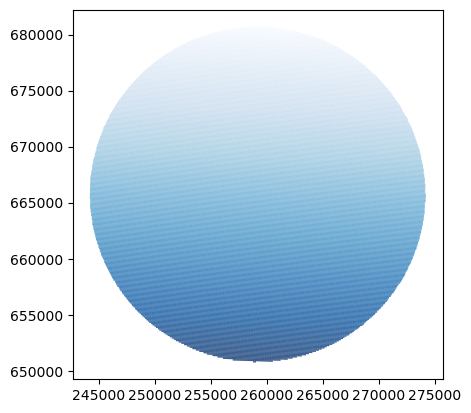

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming cells_in_circle is a GeoDataFrame
fig, ax = plt.subplots()
cells_in_circle.plot(column='row', ax=ax, cmap='Blues')
plt.show()

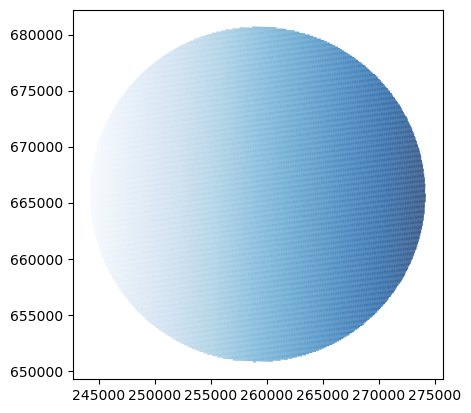

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming cells_in_circle is a GeoDataFrame
fig, ax = plt.subplots()
cells_in_circle.plot(column='col', ax=ax, cmap='Blues')
plt.show()

In [70]:
buildings_joint = buildings.sjoin(cells_in_circle, how='inner')

In [75]:
buildings_joint

,uID,geometry,building_area,building_circular_compactness,building_elongation,building_squareness,building_eri,building_orientation,building_neighbour_dist,building_neighbourhood_interbuilding_distance,...,building_elongation_weight,building_squareness_weight,building_eri_weight,building_neighbour_dist_weight,building_neighbourhood_interbuilding_distance_weight,building_orientation_weight,index_right,raster_val,row,col
730,731,"POLYGON ((253894.911 667992.009, 253874.743 66...",393.721492,0.611691,0.977599,0.023740,0.811813,3.700646,21.724937,43.350195,...,0.669812,5.215331,0.760304,64.107830,42.834806,13.247959,58469,7,119,159
12873,12874,"POLYGON ((253844.484 667989.838, 253844.622 66...",421.556464,0.580966,0.847610,0.002635,0.820254,1.435658,25.911304,49.945333,...,0.604925,8.732242,0.801672,72.185386,43.157245,14.273276,58469,7,119,159
57310,57311,"POLYGON ((253870.028 667937.639, 253870.065 66...",49.133134,0.602415,0.715249,0.006788,1.000005,0.371339,60.885293,51.805822,...,0.501917,9.155122,0.846782,59.828097,43.374552,18.457705,58469,7,119,159
90109,90110,"POLYGON ((253845.773 667944.129, 253840.136 66...",219.069831,0.660199,0.966956,0.006690,0.924825,0.399817,31.374807,50.986493,...,0.500253,9.952350,0.850382,61.422767,43.816524,18.724174,58469,7,119,159
97295,97296,"POLYGON ((253870.996 667945.712, 253850.035 66...",224.135798,0.379538,0.555722,0.010186,0.821445,9.507714,19.448789,42.507934,...,0.541014,11.419751,0.855706,69.213179,43.803296,16.317256,58469,7,119,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473449,473450,"POLYGON ((264372.714 653234.378, 264427.116 65...",2753.686882,0.302513,0.610128,0.122810,0.435995,1.059381,45.993221,47.242502,...,0.641964,5.490920,0.811462,52.904987,52.028558,23.531022,121856,6,248,336
473467,473468,"POLYGON ((260958.330 654618.664, 260946.438 65...",1118.338882,0.559094,0.594789,0.053638,1.000070,15.922027,71.916855,60.554685,...,0.590712,9.457748,0.853055,68.216367,63.623297,21.245255,116410,5,237,280
473835,473836,"POLYGON ((265325.368 652515.758, 265314.684 65...",59.539895,0.513067,0.506488,0.034472,1.000050,9.743869,81.206519,144.155284,...,0.604548,4.346888,0.819817,165.413475,157.477654,23.543051,125300,5,255,350
474335,474336,"POLYGON ((263643.071 652253.602, 263631.206 65...",167.759456,0.505564,0.494788,0.119453,1.000173,40.139908,24.377087,46.902238,...,0.433095,0.044185,0.966062,47.703523,59.433202,14.114846,126744,6,258,324


In [77]:
tessellation_new = tessellation.sjoin(cells_in_circle, how='inner')

In [80]:
tessellation_not_in_buildings = tessellation[~tessellation['uID'].isin(buildings_joint['uID'])]

<Axes: >

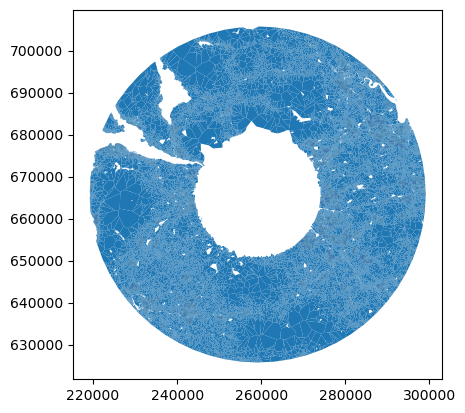

In [82]:
tessellation_not_in_buildings.plot()

In [68]:
tessellation_new.to_parquet(f"output/{place}/tessellation_cells.pq")

In [47]:
type(tessellation)

NoneType